In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load or process W2V

In [5]:
w2vModel_300 = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

KeyboardInterrupt: 

In [2]:
from sklearn.decomposition import PCA
w2vVectors = w2vModel_300.vectors
pca = PCA(n_components=100)
w2vVectors = pca.fit_transform(w2vVectors)
w2vModel_100 = KeyedVectors(vector_size=100)
w2vModel_100.add_vectors(w2vModel_300.index_to_key, w2vVectors)
w2vModel_100.save('w2vModel_100.model')


KeyboardInterrupt



In [2]:
w2vModel_100 = KeyedVectors.load('./w2vModel_100.model', mmap='r')

### Define Global Fields, Functions, Dataframe

In [3]:
N_FEATURES = 100
N_INPUT = 100
N_OUTPUT = 2
W2VMODEL = w2vModel_100

In [4]:
def preprocess_text(text):
    """
    Convert text to lower-case, remove punctuation, numbers, and excess whitespaces.
    """
    # Convert to lower case
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove excess white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text)
    return words

def text_to_vec(words, remove_stopwords=False):
    vec = np.zeros((N_INPUT + N_OUTPUT, N_FEATURES))
    for i in range(1, min(N_INPUT + N_OUTPUT, len(words))+1, 1):
        word = words[-i]
        if remove_stopwords and word in stop_words:
            continue
        if word in W2VMODEL:
            vec[-i] = W2VMODEL[word]
    return vec


In [5]:
df_test = pd.read_csv('../test.csv')
df_test.columns = ['id', 'title', 'text']
df_test.iloc[:,2] = df_test.iloc[:, 2].apply(preprocess_text)
df_test['vec'] = df_test.iloc[:, 2].apply(text_to_vec)
# show the first 5 rows
df_test.head()

,id,title,text,vec
0,4,The Race is On: Second Private Team Sets Launc...,"[spacecom, toronto, canada, a, secondteam, of,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,4,Ky. Company Wins Grant to Study Peptides (AP),"[ap, a, company, founded, by, a, chemistry, re...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,4,Prediction Unit Helps Forecast Wildfires (AP),"[ap, its, barely, dawn, when, mike, fitzpatric...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,4,Calif. Aims to Limit Farm-Related Smog (AP),"[ap, southern, californias, smogfighting, agen...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,Open Letter Against British Copyright Indoctri...,"[the, british, department, for, education, and...","[[-0.5167616605758667, -0.3002702295780182, 0...."


### Build Datasets

In [6]:
from models.utils import split_sequences
# select the texts with more than N_INPUT + N_OUTPUT words
dataset = list(df_test['vec'])
X = []
Y = []
for sample in dataset:
    X.append(sample[:N_INPUT])
    Y.append(sample[N_INPUT:N_INPUT+N_OUTPUT])
X = np.stack(X)
Y = np.stack(Y)
print(X.shape, Y.shape)

c:\Users\User\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(7599, 100, 100) (7599, 2, 100)


In [7]:
from models import MODEL_ZOO
from sklearn.model_selection import train_test_split
train_size = 1000
val_size = 500
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=val_size, train_size=train_size)
LSTMMODEL = MODEL_ZOO['lstm']

### Train Model

In [26]:
lstmModel_relu = LSTMMODEL(N_INPUT, N_OUTPUT, N_FEATURES, verbose=1, epochs=100, activation='relu')
lstmModel_relu.fit(X_train, Y_train)
mse_relu = lstmModel_relu.score(X_val, Y_val)
lstmModel_tanh = LSTMMODEL(N_INPUT, N_OUTPUT, N_FEATURES, verbose=1, epochs=100, activation='tanh')
lstmModel_tanh.fit(X_train, Y_train)
mse_tanh = lstmModel_tanh.score(X_val, Y_val)

Epoch 1/100
32/32 [==============================] - 6s 89ms/step - loss: 0.0308
Epoch 2/100
32/32 [==============================] - 3s 92ms/step - loss: 0.0298
Epoch 3/100
32/32 [==============================] - 3s 96ms/step - loss: 0.0295
Epoch 4/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0292
Epoch 5/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0288
Epoch 6/100
32/32 [==============================] - 3s 103ms/step - loss: 0.0283
Epoch 7/100
32/32 [==============================] - 2s 77ms/step - loss: 0.0280
Epoch 8/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0277
Epoch 9/100
28/32 [=========================>....] - ETA: 0s - loss: 0.0275

KeyboardInterrupt: 

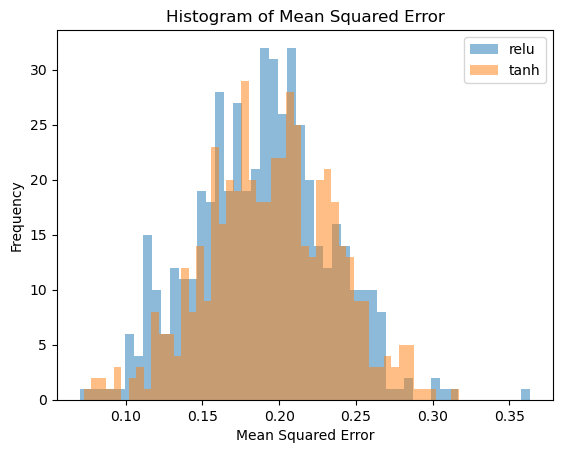

In [45]:
from matplotlib import pyplot as plt
# plot histogram of mse in one figure
plt.figure()
plt.hist(mse_relu, bins=50, alpha=0.5, label='relu')
plt.hist(mse_tanh, bins=50, alpha=0.5, label='tanh')
plt.legend(loc='upper right')
plt.title('Histogram of Mean Squared Error')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.show()

In [48]:
# save the model
lstmModel_tanh.model.save('lstmModel.model')

INFO:tensorflow:Assets written to: lstmModel.model\assets


INFO:tensorflow:Assets written to: lstmModel.model\assets


In [11]:
from keras.models import load_model
lstmModel = LSTMMODEL(N_INPUT, N_OUTPUT, N_FEATURES, verbose=1, epochs=100, activation='tanh')
lstmModel.model = load_model('lstmModel.model')
# lstmModel = lstmModel_tanh

### Predict 2 words for longest text

In [12]:
lengths = df_test['text'].apply(len)
longest_idx = lengths.idxmax()
print('Longest text index: ' + str(longest_idx))
longest_list = df_test.iloc[longest_idx, 2]
# cat words into a string
longest_text = ' '.join(longest_list)
print('Full Text: ' + longest_text)
print('Last 2 words: ' + ' '.join(longest_list[-2:]))
predicted_vecs = lstmModel.predict(X[longest_idx]).reshape(N_OUTPUT, N_FEATURES)
predicted_neighborhood = [W2VMODEL.similar_by_vector(predicted_vecs[i], topn=5) for i in range(N_OUTPUT)]
for i in range(N_OUTPUT):
    predicted_words = [predicted_neighborhood[i][j][0] for j in range(5)]
    print('Predicted next word: ' + ' '.join(predicted_words))

Longest text index: 4
Full Text: the british department for education and skills dfes recently launched a music manifesto campaign with the ostensible intention of educating the next generation of british musicians unfortunately they also teamed up with the music industry emi and various artists to make this popular emi has apparently negotiated their end well so that children in our schools will now be indoctrinated about the illegality of downloading musicthe ignorance and audacity of this got to me a little so i wrote an open letter to the dfes about it unfortunately its pedantic as i suppose you have to be when writing to goverment representatives but i hope you find it useful and perhaps feel inspired to do something similar if or when the same thing has happened in your area
Last 2 words: your area
1/1 [==============================] - 1s 718ms/step
Predicted next word: your you yourself can yours
Predicted next word: area neighborhing areas communties Heavily_populated


### f1 score on exact match
### equivalent to accuracy

In [10]:
# in the case of only selecting the top 1 word, f1 score is the same as accuracy
def classify_accuracy(model, X, y):
    y = y.reshape(-1, N_FEATURES)
    y_hat = model.predict(X)
    y_hat = y_hat.reshape(-1, N_FEATURES)
    y_nearest = np.zeros_like(y_hat)
    for i in range(y_hat.shape[0]):
        word_pred = W2VMODEL.similar_by_vector(y_hat[i], topn=1)[0][0]
        y_nearest[i] = W2VMODEL[word_pred]
    y_diff = np.where((y_nearest == y).all(axis=1), 1.0, 0.0)
    return np.mean(y_diff)

accuracy = classify_accuracy(lstmModel, X_val, Y_val)
print('Accuracy: ' + str(accuracy))

16/16 [==============================] - 0s 25ms/step
Accuracy: 0.13


In [16]:
rem_stopwords = df_test.iloc[:, 2].apply(text_to_vec, remove_stopwords=True)
# sample val_size texts
X_val_no_stopwords = []
Y_val_no_stopwords = []
rand_indices = np.random.choice(len(rem_stopwords), val_size, replace=False)
for sample in rem_stopwords[rand_indices]:
    X_val_no_stopwords.append(sample[:N_INPUT])
    Y_val_no_stopwords.append(sample[N_INPUT:N_INPUT+N_OUTPUT])
X_val_no_stopwords = np.stack(X_val_no_stopwords)
Y_val_no_stopwords = np.stack(Y_val_no_stopwords)
print(X_val_no_stopwords.shape, Y_val_no_stopwords.shape)

accuracy_no_stopwords = classify_accuracy(lstmModel, X_val_no_stopwords, Y_val_no_stopwords)
print('Accuracy without stopwords: ' + str(accuracy_no_stopwords))

(500, 100, 100) (500, 2, 100)
16/16 [==============================] - 0s 26ms/step
Accuracy without stopwords: 0.116


### BERT

In [13]:
def mask_words(words):
    return ' '.join(words[:-1]) + ' [MASK]'
texts_masked = np.array(df_test.iloc[:, 2].apply(mask_words))
target_words = np.array(df_test.iloc[:, 2].apply(lambda x: x[-1]))
rand_indices = np.random.choice(len(texts_masked), val_size, replace=False)
texts_masked_val = texts_masked[rand_indices]
target_words_val = target_words[rand_indices]
bert_model = MODEL_ZOO['bert']()
accuracy_bert = bert_model.score(texts_masked_val, target_words_val)
print('Accuracy BERT: ' + str(accuracy_bert))
masked_longest_text = mask_words(longest_list)
target_word = longest_list[-1]
predicted_word = bert_model.predict(masked_longest_text)
print("Longest text: " + longest_text)
print("Target: " + target_word)
print("Predicted: " + predicted_word)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sample 0 - Accuracy: 0.0
Sample 50 - Accuracy: 0.0
Sample 100 - Accuracy: 0.0
Sample 150 - Accuracy: 0.006622516556291391
Sample 200 - Accuracy: 0.004975124378109453
Sample 250 - Accuracy: 0.00398406374501992
Sample 300 - Accuracy: 0.0033222591362126247
Sample 350 - Accuracy: 0.002849002849002849
Sample 400 - Accuracy: 0.004987531172069825
Sample 450 - Accuracy: 0.004434589800443459
Accuracy BERT: 0.004
Longest text: the british department for education and skills dfes recently launched a music manifesto campaign with the ostensible intention of educating the next generation of british musicians unfortunately they also teamed up with the music industry emi and various artists to make this popular emi has apparently negotiated their end well so that children in our schools will now be indoctrinated about the illegality of downloading musicthe ignorance and audacity of this got to me a little so i wrote an open letter to the dfes about it unfortunately its pedantic as i suppose you have 

### GPT


In [15]:
texts_prompt = np.array(df_test.iloc[:, 2].apply(lambda x: ' '.join(x[:-1])))
target_words = np.array(df_test.iloc[:, 2].apply(lambda x: x[-1]))
rand_indices = np.random.choice(len(texts_prompt), val_size, replace=False)
texts_prompt_val = texts_prompt[rand_indices]
target_words_val = target_words[rand_indices]
bert_model = MODEL_ZOO['gpt']()
accuracy_bert = bert_model.score(texts_prompt_val, target_words_val)
print('Accuracy GPT: ' + str(accuracy_bert))
prompt_longest_text = ' '.join(longest_list[:-1])
target_word = longest_list[-1]
predicted_word = bert_model.predict(prompt_longest_text)
print("Longest text: " + longest_text)
print("Target: " + target_word)
print("Predicted: " + predicted_word)

Sample 0 - Accuracy: 0.0
Sample 50 - Accuracy: 0.0
Sample 100 - Accuracy: 0.0
Sample 150 - Accuracy: 0.0
Sample 200 - Accuracy: 0.0
Sample 250 - Accuracy: 0.0
Sample 300 - Accuracy: 0.0
Sample 350 - Accuracy: 0.0
Sample 400 - Accuracy: 0.0
Sample 450 - Accuracy: 0.0
Accuracy GPT: 0.0
Longest text: the british department for education and skills dfes recently launched a music manifesto campaign with the ostensible intention of educating the next generation of british musicians unfortunately they also teamed up with the music industry emi and various artists to make this popular emi has apparently negotiated their end well so that children in our schools will now be indoctrinated about the illegality of downloading musicthe ignorance and audacity of this got to me a little so i wrote an open letter to the dfes about it unfortunately its pedantic as i suppose you have to be when writing to goverment representatives but i hope you find it useful and perhaps feel inspired to do something si

### Topic Mining

In [26]:
import gensim
import matplotlib.pyplot as plt
cDict = gensim.corpora.Dictionary(df_test.iloc[:, 2])
matrix = [cDict.doc2bow(words) for words in df_test.iloc[:, 2]]
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(matrix, num_topics=10, id2word=cDict, passes=15)

def plot_top_words(lda_model, topic_id, num_words):
    terms = lda_model.show_topic(topic_id, num_words)
    terms = dict(terms)
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(terms)), list(terms.values()), tick_label=list(terms.keys()))
    plt.title('Top Words in Topic #{}'.format(topic_id))
    plt.xlabel('Terms')
    plt.ylabel('Weight')
    plt.show()

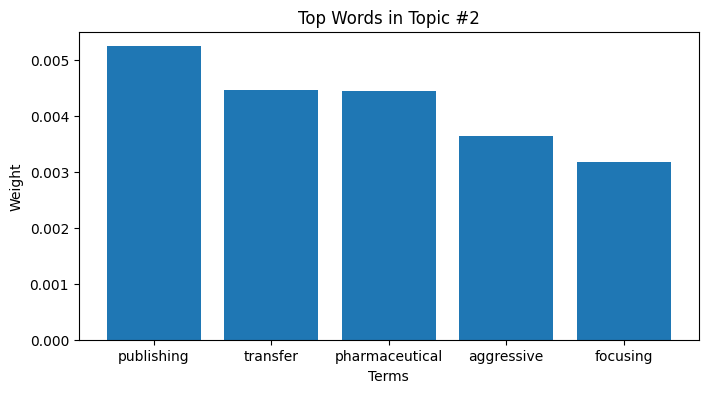

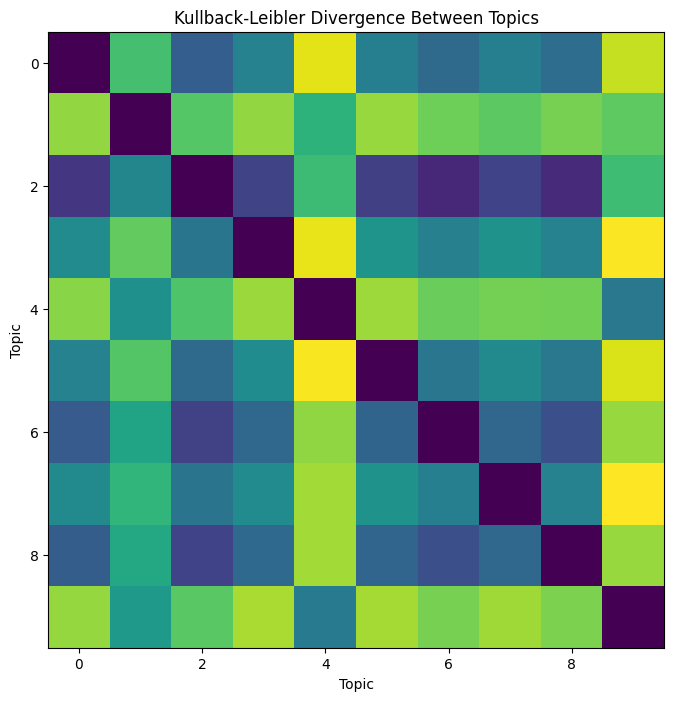

In [31]:
import matplotlib.pyplot as plt
plot_top_words(ldamodel, topic_id=2, num_words=5)


topic_diff = ldamodel.diff(ldamodel, distance='kullback_leibler', num_words=50)[0]

plt.figure(figsize=(10, 8))
plt.imshow(topic_diff, cmap='viridis', interpolation='nearest')
plt.title('Kullback-Leibler Divergence Between Topics')
plt.xlabel('Topic')
plt.ylabel('Topic')
plt.show()